                Name:Arra Sai Nitish Reddy    Roll:R177219050   Bath:CSC-AI&Ml-2

In [100]:
from glob import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchsummary import summary
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline
import cv2
from PIL import Image as im
from PIL import Image

In [2]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)


In [3]:
def feature_extraction(img):
    df = pd.DataFrame()
    
    org=img
    img0=org[:,:,64,0]
    img1=org[:,:,64,1]
    img2=org[:,:,64,2]
    
    
    img0=img0.reshape(128,128)
    img1=img1.reshape(128,128)
    img2=img2.reshape(128,128)
   

    img20 = img0.reshape(-1)
    img21 = img1.reshape(-1)
    img22 = img2.reshape(-1)
    
    df['Original Image0'] = img20
    df['Original Image1'] = img21
    df['Original Image2'] = img22
    
#Generate Gabor features
    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
#               print(theta, sigma, , lamda, frequency)
                
                    gabor_label0 = 'Gabor0' + str(num)
                    gabor_label1 = 'Gabor1' + str(num)
                    gabor_label2 = 'Gabor2' + str(num)
#                    print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter image and add values to new column
                    fimg0 = cv2.filter2D(img20, cv2.CV_8UC3, kernel)
                    fimg1 = cv2.filter2D(img21, cv2.CV_8UC3, kernel)
                    fimg2 = cv2.filter2D(img22, cv2.CV_8UC3, kernel)
                    
                    filtered_img0 = fimg0.reshape(-1)
                    filtered_img1 = fimg1.reshape(-1)
                    filtered_img2 = fimg2.reshape(-1)
                    
                    
                    df[gabor_label0] = filtered_img0  #Modify this to add new column for each gabor
                    df[gabor_label1] = filtered_img1
                    df[gabor_label2] = filtered_img2

                    num += 1
    return df

In [129]:
img_df=[]
for idd in train_img_list:
   
    img=np.load("BraTS2020_TrainingData/input_data_128/train/images/"+idd)
    d=feature_extraction(img)
    img_df+=[d]

In [125]:

mask_all=[]

for index,idd in enumerate(train_mask_list): 
    df_mask_all=pd.DataFrame()
    
    org=np.load("BraTS2020_TrainingData/input_data_128/train/masks/"+idd)
    msk_img=org[:,:,64,0]
    msk_img=msk_img.reshape(128,128)
    msk_img=msk_img.reshape(-1)
    df_mask_all['lable0']=msk_img

    msk_img=org[:,:,64,1]
    msk_img=msk_img.reshape(128,128)
    msk_img=msk_img.reshape(-1)
    df_mask_all['lable1']=msk_img

    msk_img=org[:,:,64,2]
    msk_img=msk_img.reshape(128,128)
    msk_img=msk_img.reshape(-1)
    df_mask_all['lable2']=msk_img
    
    mask_all+=[df_mask_all]
    

In [130]:
img_df[0]

,Original Image0,Original Image1,Original Image2,Gabor01,Gabor11,Gabor21,Gabor02,Gabor12,Gabor22,Gabor03,...,Gabor229,Gabor030,Gabor130,Gabor230,Gabor031,Gabor131,Gabor231,Gabor032,Gabor132,Gabor232
0,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16380,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16381,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16382,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
mask_all[0]

,lable0,lable1,lable2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
16379,1.0,0.0,0.0
16380,1.0,0.0,0.0
16381,1.0,0.0,0.0
16382,1.0,0.0,0.0


In [133]:
from sklearn.tree import DecisionTreeClassifier


In [136]:
import joblib as joblib
for i in range(len(mask_all)):
    clf=DecisionTreeClassifier(random_state=0)
    clf.fit(img_df[i],mask_all[i])
    
    s='Trained models1/model_pkl_'+str(i)
    print(joblib.dump(clf , s))

['Trained models1/model_pkl_0']
['Trained models1/model_pkl_1']
['Trained models1/model_pkl_2']
['Trained models1/model_pkl_3']
['Trained models1/model_pkl_4']
['Trained models1/model_pkl_5']
['Trained models1/model_pkl_6']
['Trained models1/model_pkl_7']
['Trained models1/model_pkl_8']
['Trained models1/model_pkl_9']
['Trained models1/model_pkl_10']
['Trained models1/model_pkl_11']
['Trained models1/model_pkl_12']
['Trained models1/model_pkl_13']
['Trained models1/model_pkl_14']
['Trained models1/model_pkl_15']
['Trained models1/model_pkl_16']
['Trained models1/model_pkl_17']
['Trained models1/model_pkl_18']
['Trained models1/model_pkl_19']
['Trained models1/model_pkl_20']
['Trained models1/model_pkl_21']
['Trained models1/model_pkl_22']
['Trained models1/model_pkl_23']
['Trained models1/model_pkl_24']
['Trained models1/model_pkl_25']
['Trained models1/model_pkl_26']
['Trained models1/model_pkl_27']
['Trained models1/model_pkl_28']
['Trained models1/model_pkl_29']
['Trained models1/mo

['Trained models1/model_pkl_245']
['Trained models1/model_pkl_246']
['Trained models1/model_pkl_247']
['Trained models1/model_pkl_248']
['Trained models1/model_pkl_249']
['Trained models1/model_pkl_250']
['Trained models1/model_pkl_251']
['Trained models1/model_pkl_252']
['Trained models1/model_pkl_253']
['Trained models1/model_pkl_254']
['Trained models1/model_pkl_255']
['Trained models1/model_pkl_256']
['Trained models1/model_pkl_257']


In [137]:
nu_model=len(img_df)

In [198]:
def pred(img):
    
        
    #img=feature_extraction(img)
    
    pred0=np.zeros(len(img))
    pred1=np.zeros(len(img))
    pred2=np.zeros(len(img))
    for i in range(nu_model):
        s='Trained models1/model_pkl_'+str(i)
        clf=joblib.load(s)
        p=np.array(clf.predict(img))
        
        pred0+=p[:,0]
        pred1+=p[:,1]
        pred2+=p[:,2]
        
    pred0=pred0/nu_model 
    pred1=pred1/nu_model 
    pred2=pred2/nu_model 
    
    pred=pd.DataFrame()
    pred['lable0']=pred0
    pred['lable1']=pred1
    pred['lable2']=pred2
            
        
    return pred/nu_model

        

In [199]:
pdr=pred(img_df[0])


In [200]:
pdr

,lable0,lable1,lable2
0,0.003876,0.0,0.0
1,0.003876,0.0,0.0
2,0.003876,0.0,0.0
3,0.003876,0.0,0.0
4,0.003876,0.0,0.0
...,...,...,...
16379,0.003876,0.0,0.0
16380,0.003876,0.0,0.0
16381,0.003876,0.0,0.0
16382,0.003876,0.0,0.0


# Evaluating on unseen data

In [201]:
def plt_img(v):
    img=np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(v)+".npy")
    img=feature_extraction(img)
    pdr=pred(img)



    df_mask_all=pd.DataFrame()
    org=np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(v)+".npy")
    msk_img=org[:,:,64,0]
    msk_img=msk_img.reshape(128,128)
    msk_img=msk_img.reshape(-1)
    df_mask_all['lable0']=msk_img

    msk_img=org[:,:,64,1]
    msk_img=msk_img.reshape(128,128)
    msk_img=msk_img.reshape(-1)
    df_mask_all['lable1']=msk_img

    msk_img=org[:,:,64,2]
    msk_img=msk_img.reshape(128,128)
    msk_img=msk_img.reshape(-1)
    df_mask_all['lable2']=msk_img
    
    




    msk_org=mask_all[0]
    plt.figure(1)

    plt.subplot(321)
    msk0=np.array(pdr['lable0'])
    msk0=msk0.reshape(128,128)
    plt.imshow(msk0)

    plt.subplot(322)
    msk0=np.array(df_mask_all['lable0'])
    msk0=msk0.reshape(128,128)
    plt.imshow(msk0)



    plt.subplot(323)
    msk0=np.array(pdr['lable1'])
    msk0=msk0.reshape(128,128)
    plt.imshow(msk0)

    plt.subplot(324)
    msk0=np.array(df_mask_all['lable1'])
    msk0=msk0.reshape(128,128)
    plt.imshow(msk0)




    plt.subplot(325)
    msk0=np.array(pdr['lable2'])
    msk0=msk0.reshape(128,128)
    plt.imshow(msk0)

    plt.subplot(326)
    msk0=np.array(df_mask_all['lable2'])
    msk0=msk0.reshape(128,128)
    plt.imshow(msk0)

    plt.show()



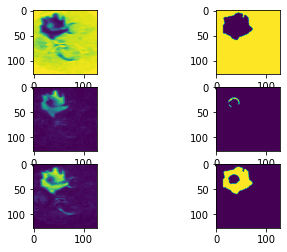

In [202]:
plt_img(192)

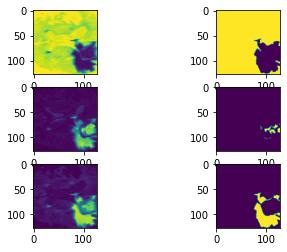

In [203]:
plt_img(200)

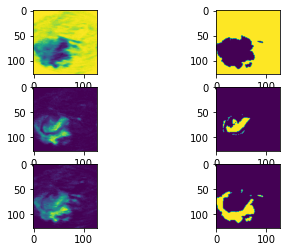

In [204]:
plt_img(209)

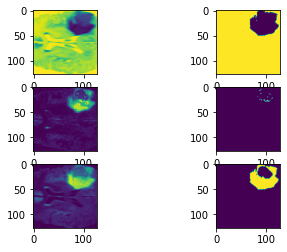

In [205]:
plt_img(256)

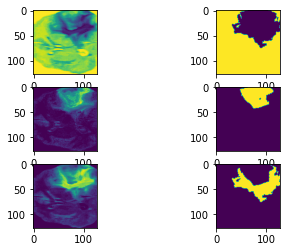

In [206]:
plt_img(322)

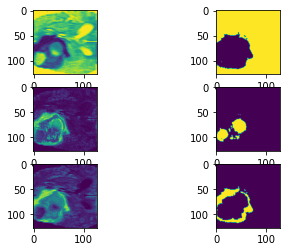

In [207]:
plt_img(251)

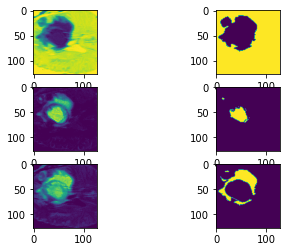

In [208]:
plt_img(234)